# XAI methods for text data

In [ ]:
import sklearn
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import shap
import lime
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.6.2


# LIME for NLP


## converting unstructured text into vectores by using Tfidf vectorizer

In [ ]:
from gensim.utils import simple_preprocess
path = r'./data/bbc.csv'
df = pd.read_csv(path)
from sklearn.model_selection import train_test_split
X = df['text']
class_names = ['business', 'sport', 'politics', 'tech','entertainment']
class_dict = {'business':0, 'sport':1, 'politics':2, 'tech':3, 'entertainment':4}
y = df['label'].map(class_dict)

# Splitting X & y into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.90, random_state=1963)

y_train.reset_index()
y_test.reset_index()
X_train = [simple_preprocess(doc) for doc in X_train] 
X_test = [simple_preprocess(doc) for doc in X_test]

print(f'max length of train instances is {len(max(X_train))}')
print(f'max length of train instances is {len(max(X_test))}')

X_train = [' '.join(doc_list) for doc_list in X_train]
X_test = [' '.join(doc_list) for doc_list in X_test]

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False)
train_vectors_tfidf = vectorizer.fit_transform(X_train)
test_vectors_tfidf = vectorizer.transform(X_test)

max length of train instances is 259
max length of train instances is 125
CPU times: user 1.44 s, sys: 61.8 ms, total: 1.5 s
Wall time: 1.73 s


## Training a Random Forest Classifier as a black box model

In [ ]:
# Instantiating the prediction model as a black box model- a Random Forest Regressor
# Features with different scales make it really hard to interpret.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Creating the grid search for hyper-tuning
random_forest_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'criterion': ['gini', 'entropy', 'log_loss'],
               'max_features': ['auto','log2', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
def create_black_box_model(xtrain, ytrain, xtest, ytest, model, grid):
    #initializing the model
    black_box_model = model()
    # Hyper-tuning the parameters 
    grid_search = RandomizedSearchCV(estimator = black_box_model, param_distributions = grid, n_iter = 10, cv = 5, verbose=2, random_state=1963, n_jobs = -1)
    
    # Fitting the grid search onto the training set
    grid_search.fit(xtrain, ytrain)

    # Checking the model's best parameters 
    print(f'Best parameters = {grid_search.best_params_}')
    # Checking the model's performance on the test set
    print(f'Score for the model on test set = {grid_search.best_estimator_.score(xtest, ytest)}')
    return grid_search.best_estimator_

black_box_text_classifier = create_black_box_model(train_vectors_tfidf, y_train, test_vectors_tfidf, y_test, RandomForestClassifier, random_forest_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


One or more of the test scores are non-finite: [0.9690187  0.95302494 0.96452244        nan 0.96402369 0.96502369
 0.89305486 0.95102618 0.9675187         nan]


Best parameters = {'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, 'criterion': 'gini', 'bootstrap': False}
Score for the model on test set = 0.9551569506726457
CPU times: user 11.3 s, sys: 1.1 s, total: 12.4 s
Wall time: 42.4 s


## LIME Explanation for black box model + TFIDF vectorizer

In [2]:
# Importing the module for LimeTabularExplainer
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
text_pipeline = make_pipeline(vectorizer, black_box_text_classifier)

# Instantiating the explainer object by passing in the training set, and the extracted features
explainer_lime = LimeTextExplainer(class_names=class_names)

# Index corresponding to the 5 random test vectors
index_list = np.random.randint(len(X_test), size=1)
# Number denoting the top features
num_top_features = 10
# Calling the explain_instance method by passing in the:
#    1) ith test vector
#    2) prediction function used by our prediction model('black_box_regressor' in this case)
#    3) the top features which we want to see, denoted by num_top_features
for i in index_list:
    fig = plt.gcf()
    exp_lime = explainer_lime.explain_instance(X_test[i], text_pipeline.predict_proba, num_features=num_top_features, top_labels=1)
    # Finally visualizing the explanations
    class_dict_reverse = {v:k for k,v in class_dict.items()}
    print(f'True label is : {class_dict_reverse[y_test.iloc[i]]}')
    exp_lime.show_in_notebook(text=X_test[i])
    fig = exp_lime.as_pyplot_figure()
    fig.savefig(f'./result/text/lime/tfidf/lime_text_bbcnews_datapoint_{i}.png', dpi=300, bbox_inches="tight")
    exp_lime.save_to_file(f'./result/text/lime/tfidf/lime_text_bbcnews_datapoint_{i}.html')


[link text](https://)## SHAP Explanation for black box model + TFIDF vectorizer

True label is : tech


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:12, 12.31s/it]               


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


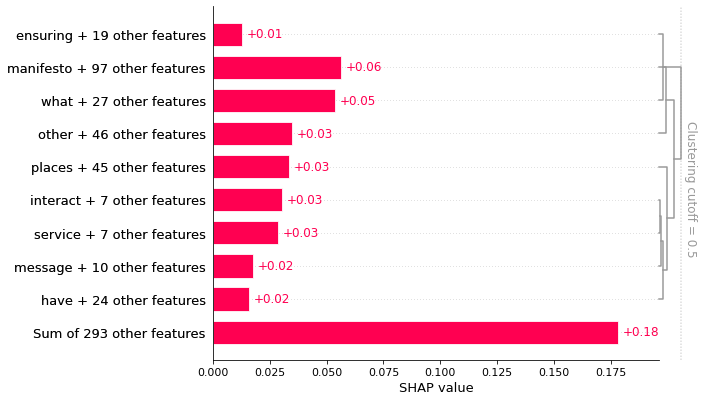

CPU times: user 35.2 s, sys: 259 ms, total: 35.5 s
Wall time: 36.3 s


In [ ]:
import shap

for i in index_list:
    exp_shap = shap.Explainer(text_pipeline.predict_proba, masker=shap.maskers.Text(tokenizer=r"\W+"), output_names=class_names, partition_tree=True)
    # Finally visualizing the explanations
    class_dict_reverse = {v:k for k,v in class_dict.items()}
    print(f'True label is : {class_dict_reverse[y_test.iloc[i]]}')
    shap_values = exp_shap(X_test[i:i+1]) # list should pass to shap explainer
    shap.text_plot(shap_values)
    fig1 = plt.gcf()
    fig1.savefig(f'./result/text/shap/tfidf/shap_text_forceplot_bbcnews_datapoint_{i}.jpg')
    plt.close()
    print('-'*250)
    shap.plots.bar(shap_values[0,:, np.argmax(np.mean(shap_values.values, axis=(0, 1)))], order=shap.Explanation.argsort)
    fig2 = plt.gcf()
    fig2.savefig(f'./result/text/shap/tfidf/shap_text_barplot_bbcnews_datapoint_{i}.jpg')
    plt.close()
    
# class_dict_reverse[np.argmax(np.mean(shap_values.values, axis=(0, 1)))]
# shap_values.data[0][np.argsort(np.mean(shap_values.values, axis=(0,2)))[-20:]]

## Embedding unstructured text into vectors by using transformer-based language model for embeddings

In [ ]:
tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')

train_tokens = tokenizer(X_train, max_length=512, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
test_tokens = tokenizer(X_test, max_length=512, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')

roberta_model = transformers.TFRobertaModel.from_pretrained("roberta-base")
train_embedded = roberta_model(**train_tokens).pooler_output
test_embedded = roberta_model(**test_tokens).pooler_output

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


CPU times: user 4h 24min 32s, sys: 6min 30s, total: 4h 31min 2s
Wall time: 5min 37s


## Training a Random Forest Classifier as a black box model

In [1]:
# Instantiating the prediction model as a black box model- a Random Forest Regressor
# Features with different scales make it really hard to interpret.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Creating the grid search for hyper-tuning
random_forest_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'criterion': ['gini', 'entropy', 'log_loss'],
               'max_features': ['auto','log2', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
def create_black_box_model(xtrain, ytrain, xtest, ytest, model, grid):
    #initializing the model
    black_box_model = model()
    # Hyper-tuning the parameters 
    grid_search = RandomizedSearchCV(estimator = black_box_model, param_distributions = grid, n_iter = 10, cv = 5, verbose=0, random_state=1963, n_jobs = -1)
    
    # Fitting the grid search onto the training set
    grid_search.fit(xtrain, ytrain)

    # Checking the model's performance on the test set
    print(f'Score for the model on test set = {grid_search.best_estimator_.score(xtest, ytest)}')
    return grid_search.best_estimator_

black_box_text_classifier_roberta = create_black_box_model(train_embedded.numpy(), y_train, test_embedded.numpy(), y_test, RandomForestClassifier, random_forest_grid)

## LIME Explanation for black box model + RoBERTa embedded vectors


In [ ]:
from lime.lime_text import LimeTextExplainer
text_pipeline_roberta = lambda x:  black_box_text_classifier_roberta.predict_proba(roberta_model(**tokenizer(x, max_length=512, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')).pooler_output.numpy())
class_dict_reverse = {v:k for k,v in class_dict.items()}

#instantiating the explainer object by passing in the training set, and the extracted features
explainer_lime = LimeTextExplainer(class_names=class_names)

#number denoting the top features 
num_top_features = 10 

for i in index_list:
    exp_lime = explainer_lime.explain_instance(text_instance=X_test[i], classifier_fn=text_pipeline_roberta, num_features=num_top_features, num_samples=2000, top_labels=1)
    print(f'True Label is : {class_dict_reverse[y_test.iloc[i]] }')
    exp_lime.show_in_notebook(text=X_test[i])
    plt.savefig(f'./result/text/lime/bert/lime_text_bbcnews_datapoint_{i}.jpg')

## SHAP Local Explanation for black box model + RoBERTa embedded vectors

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
True label is : tech


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [01:45, 105.79s/it]              


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


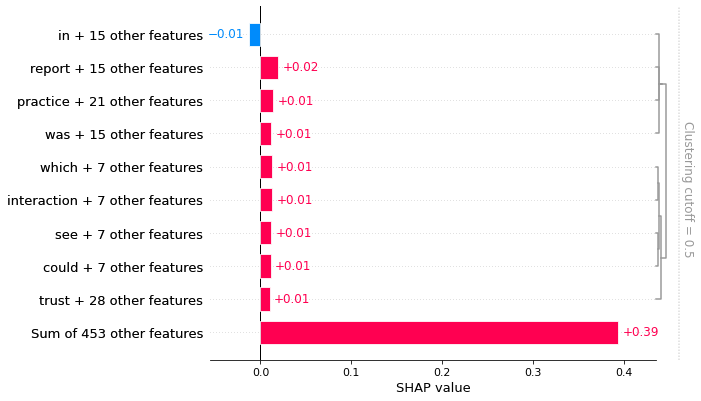

CPU times: user 55min 41s, sys: 1min 26s, total: 57min 7s
Wall time: 2min 8s


In [ ]:
import shap

for i in index_list:
    exp_shap = shap.Explainer(text_pipeline_roberta, masker=shap.maskers.Text(tokenizer=r"\W+"), output_names=class_names, partition_tree=True)
    # Finally visualizing the explanations
    class_dict_reverse = {v:k for k,v in class_dict.items()}
    print(f'True label is : {class_dict_reverse[y_test.iloc[i]]}')
    shap_values = exp_shap(np.array(X_test[i:i+1])) # list should pass to shap explainer
    shap.text_plot(shap_values)
    print('-'*250)
    fig1 = plt.gcf()
    fig1.savefig(f'./result/text/shap/bert/shap_text_barplot_bbcnews_datapoint_{i}.jpg')
    plt.close()
    shap.plots.bar(shap_values[0,:, np.argmax(np.mean(shap_values.values, axis=(0, 1)))], order=shap.Explanation.argsort) # use mean in axis zero if you have more test instances 
    print('='*250)
    fig2 = plt.gcf()
    fig2.savefig(f'./result/text/shap/bert/shap_text_barplot_bbcnews_datapoint_{i}.jpg')
    plt.close()
# class_dict_reverse[np.argmax(np.mean(shap_values.values, axis=(0, 1)))]
# shap_values.data[0][np.argsort(np.mean(shap_values.values, axis=(0,2)))[-20:]]